In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6


import os
import copy
import time
import pickle
import numpy as np
from tqdm import tqdm

import torch
from tensorboardX import SummaryWriter

from options import args_parser
from update import LocalUpdate, test_inference
from models import MLP, CNNMnist, CNNFashion_Mnist, CNNCifar
from utils import get_dataset, average_weights, exp_details

In [2]:
import argparse

parser = argparse.ArgumentParser()
# parser.add_argument('--name', '-n', default='foo', help='foo')
parser.add_argument('--model', type=str, default='mlp', help='model name(mlp or cnn)')
parser.add_argument('--dataset', type=str, default='mnist', help="name of dataset(mnist or cifar)")
parser.add_argument('--epochs', type=int, default=5, help="number of rounds of training(10)")
parser.add_argument('--num_users', type=int, default=100, help="number of users: K")
parser.add_argument('--num_classes', type=int, default=10, help="number of classes")
parser.add_argument('--gpu', default=1, help="To use cuda, set to a specific GPU ID. Default set to use CPU.")
parser.add_argument('--frac', type=float, default=0.1, help='the fraction of clients: C')
parser.add_argument('--local_ep', type=int, default=3, help="the number of local epochs: E")
parser.add_argument('--local_bs', type=int, default=10, help="local batch size: B")
parser.add_argument('--lr', type=float, default=0.01, help='learning rate')
parser.add_argument('--optimizer', type=str, default='sgd', help="type of optimizer")
parser.add_argument('--verbose', type=int, default=1, help='verbose')
parser.add_argument('--iid', type=int, default=1, help='Default set to IID. Set to 0 for non-IID.')
parser.add_argument('--unequal', type=int, default=0, help='whether to use unequal data splits for  \
                        non-i.i.d setting (use 0 for equal splits)')
# parser.add_argument('--seed', type=int, default=1, help='random seed')

parser.add_argument('--num_clusters', type=int, default=2, help='verbose')


# args = parser.parse_args([])
args, _ = parser.parse_known_args()

args
# --dataset=mnist --gpu=0 --iid=0 --epochs=10

Namespace(dataset='mnist', epochs=5, frac=0.1, gpu=None, iid=1, local_bs=10, local_ep=3, lr=0.01, model='mlp', num_classes=10, num_clusters=2, num_users=100, optimizer='sgd', unequal=0, verbose=1)

In [3]:
# if __name__ == '__main__':
start_time = time.time()
print("start time: ", start_time)

# define paths
path_project = os.path.abspath('..')
logger = SummaryWriter('../logs')

# args = args_parser()
# exp_details(args)

start time:  1571373590.742761


In [4]:
if args.gpu:
    torch.cuda.set_device(args.gpu)
device = 'cuda' if args.gpu else 'cpu'

In [5]:
# load dataset and user groups
train_dataset, test_dataset, user_groups = get_dataset(args)

In [6]:
# Splitting into clusters. FL groups
cluster_size = args.num_users / args.num_clusters
print("Each cluster size: ", cluster_size)

# Cluster 1
A1 = np.arange(cluster_size, dtype=int)
user_groupsA = {k:user_groups[k] for k in A1 if k in user_groups}
print("Size of cluster 1: ", len(user_groupsA))
# Cluster 2
B1 = np.arange(cluster_size, cluster_size+cluster_size, dtype=int)
user_groupsB = {k:user_groups[k] for k in B1 if k in user_groups}
print("Size of cluster 2: ", len(user_groupsB))

Each cluster size:  50.0
Size of cluster 1:  50
Size of cluster 2:  50


In [7]:
# Check that clusters are all different
print(user_groupsA.keys())
print(user_groupsB.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
dict_keys([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])


In [8]:
# BUILD MODEL
def build_model(args, train_dataset):
    if args.model == 'cnn':
        # Convolutional neural network
        if args.dataset == 'mnist':
            global_model = CNNMnist(args=args)
        elif args.dataset == 'fmnist':
            global_model = CNNFashion_Mnist(args=args)
        elif args.dataset == 'cifar':
            global_model = CNNCifar(args=args)

    elif args.model == 'mlp':
        # Multi-layer preceptron
        img_size = train_dataset[0][0].shape
        len_in = 1
        for x in img_size:
            len_in *= x
            global_model = MLP(dim_in=len_in, dim_hidden=200,
                               dim_out=args.num_classes)
    else:
        exit('Error: unrecognized model')
        
    return global_model

In [9]:
# MODEL PARAM SUMMARY
global_model = build_model(args, train_dataset)
pytorch_total_params = sum(p.numel() for p in global_model.parameters())
print(pytorch_total_params)

from torchsummary import summary

summary(global_model, (1, 28, 28))
global_model.parameters()

199210
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
           Dropout-2                  [-1, 200]               0
              ReLU-3                  [-1, 200]               0
            Linear-4                  [-1, 200]          40,200
           Dropout-5                  [-1, 200]               0
              ReLU-6                  [-1, 200]               0
            Linear-7                   [-1, 10]           2,010
           Softmax-8                   [-1, 10]               0
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


<generator object Module.parameters at 0x7fed31502d68>

In [10]:
# Set the model to train and send it to device.
global_model.to(device)
global_model.train()
print(global_model)

# copy weights
global_weights = global_model.state_dict()

MLP(
  (layer_input): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden1): Linear(in_features=200, out_features=200, bias=True)
  (layer_hidden2): Linear(in_features=200, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [11]:
# Set the cluster models to train and send it to device.
cluster_modelA = build_model(args, train_dataset)
cluster_modelA.to(device)
cluster_modelA.train()
# copy weights
cluster_modelA_weights = cluster_modelA.state_dict()

# Set the cluster models to train and send it to device.
cluster_modelB = build_model(args, train_dataset)
cluster_modelB.to(device)
cluster_modelB.train()
# copy weights
cluster_modelB_weights = cluster_modelA.state_dict()

In [12]:
# Defining the training function
def fl_train(args, train_dataset, cluster_global_model, cluster, usergrp, epochs):
#     print(args)
    
#     # Set the model to train and send it to device.
#     cluster_global_model = build_model(args, train_dataset)
#     cluster_global_model.to(device)
#     cluster_global_model.train()

#     # copy weights
#     cluster_global_weights = cluster_global_model.state_dict()
    
    cluster_train_loss, cluster_train_accuracy = [], []
    cluster_val_acc_list, cluster_net_list = [], []
    cluster_cv_loss, cluster_cv_acc = [], []
    print_every = 2
    cluster_val_loss_pre, counter = 0, 0

    for epoch in tqdm(range(epochs)):
        cluster_local_weights, cluster_local_losses = [], []
        print(f'\n | Cluster Training Round : {epoch+1} |\n')

        cluster_global_model.train()
        m = max(int(args.frac * len(cluster)), 1)
        idxs_users = np.random.choice(cluster, m, replace=False)


        for idx in idxs_users:
            cluster_local_model = LocalUpdate(args=args, dataset=train_dataset, idxs=usergrp[idx], logger=logger)
            cluster_w, cluster_loss = cluster_local_model.update_weights(model=copy.deepcopy(cluster_global_model), global_round=epoch)
            cluster_local_weights.append(copy.deepcopy(cluster_w))
            cluster_local_losses.append(copy.deepcopy(cluster_loss))

        # averaging global weights
        cluster_global_weights = average_weights(cluster_local_weights)

        # update global weights
        cluster_global_model.load_state_dict(cluster_global_weights)

        cluster_loss_avg = sum(cluster_local_losses) / len(cluster_local_losses)
        cluster_train_loss.append(cluster_loss_avg)

#         # Calculate avg training accuracy over all users at every epoch
#         cluster_list_acc, cluster_list_loss = [], []
#         cluster_global_model.eval()
        
#         for c in range(len(cluster)):
#             cluster_local_model = LocalUpdate(args=args, dataset=train_dataset,
#                                       idxs=usergrp[idx], logger=logger)
#             cluster_acc, cluster_loss = cluster_local_model.inference(model=cluster_global_model)
#             cluster_list_acc.append(cluster_acc)
#             cluster_list_loss.append(cluster_loss)
#         cluster_train_accuracy.append(sum(cluster_list_acc)/len(cluster_list_acc))
    
#     return cluster_global_model, cluster_train_loss #cluster_global_weights, cluster_loss_avg, cluster_train_accuracy 
    return cluster_global_weights, cluster_loss_avg
    
# A_model, A_weights, A_losses, A_trainacc = fl_train(args, train_dataset, cluster_modelA, A1, user_groupsA, 2)    
# A_model, A_trainloss = fl_train(args, train_dataset, cluster_modelA, A1, user_groupsA, 2)
# A_weights, A_losses = fl_train(args, train_dataset, cluster_modelA, A1, user_groupsA, 2)

### Main training

In [13]:
train_loss, train_accuracy = [], []
val_acc_list, net_list = [], []
cv_loss, cv_acc = [], []
print_every = 1
val_loss_pre, counter = 0, 0

for epoch in tqdm(range(args.epochs)):
    local_weights, local_losses, local_accuracies= [], [], []
    print(f'\n | Global Training Round : {epoch+1} |\n')
    
    # ============== TRAIN ==============
    global_model.train()
    
    # Cluster A
    A_weights, A_losses = fl_train(args, train_dataset, cluster_modelA, A1, user_groupsA, 2)
    local_weights.append(copy.deepcopy(A_weights))
    local_losses.append(copy.deepcopy(A_losses))
    
    # Cluster B
    B_weights, B_losses = fl_train(args, train_dataset, cluster_modelB, B1, user_groupsB, 2)
    local_weights.append(copy.deepcopy(B_weights))
    local_losses.append(copy.deepcopy(B_losses))
    
    
    # averaging global weights
    global_weights = average_weights(local_weights)

    # update global weights
    global_model.load_state_dict(global_weights)

    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)
    
    # ============== EVAL ============== 
    # Calculate avg training accuracy over all users at every epoch
    list_acc, list_loss = [], []
    global_model.eval()
    for c in range(args.num_users):
        local_model = LocalUpdate(args=args, dataset=train_dataset,
                                  idxs=user_groups[c], logger=logger)
        acc, loss = local_model.inference(model=global_model)
        list_acc.append(acc)
        list_loss.append(loss)
    train_accuracy.append(sum(list_acc)/len(list_acc))
    
    # print global training loss after every 'i' rounds
    if (epoch+1) % print_every == 0:
        print(f' \nAvg Training Stats after {epoch+1} global rounds:')
        print(f'Training Loss : {np.mean(np.array(train_loss))}')
        print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]))
#         print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1][0]))

print('\n Total Run Time: {0:0.4f}'.format(time.time()-start_time))

  0%|          | 0/2 [00:00<?, ?it/s]/home/wesleyjtann/federated_learning/Hierarchical-Federated-Learning-Quantization/src/update.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)



 | Global Training Round : 1 |


 | Cluster Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.100857
| Global Round : 0 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.100047
| Global Round : 0 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.112111
| Global Round : 0 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.100246
| Global Round : 0 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.104230
| Global Round : 0 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.113424
| Global Round : 0 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.096679
| Global Round : 0 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.107666
| Global Round : 0 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.103782
| Global Round : 0 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.107227
| Global Round : 0 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.103962
| Global Round : 0 | Local Epoch : 2 | [100/480 (21%)]	Loss: -0.112365
| Global Round : 0 | Local Epoch : 2 | [200/480 (42%)]	Loss: -0.094971
| Global Round : 0 


 50%|█████     | 1/2 [00:03<00:03,  3.33s/it]

| Global Round : 0 | Local Epoch : 2 | [400/480 (83%)]	Loss: -0.098218

 | Cluster Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.098466
| Global Round : 1 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.109916
| Global Round : 1 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.106987
| Global Round : 1 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.108120
| Global Round : 1 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.112795
| Global Round : 1 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.098149
| Global Round : 1 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.109277
| Global Round : 1 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.107090
| Global Round : 1 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.124893
| Global Round : 1 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.104270
| Global Round : 1 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.112728
| Global Round : 1 | Local Epoch : 2 | [100/480 (21%)]	Loss: -0.136079
| Global Round : 1 | Local Epoch : 2 | [200/480 (42%


100%|██████████| 2/2 [00:06<00:00,  3.30s/it]

  0%|          | 0/2 [00:00<?, ?it/s]


 | Cluster Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.101080
| Global Round : 0 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.109916
| Global Round : 0 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.097413
| Global Round : 0 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.100618
| Global Round : 0 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.103357
| Global Round : 0 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.093933
| Global Round : 0 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.105164
| Global Round : 0 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.103412
| Global Round : 0 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.098486
| Global Round : 0 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.104743
| Global Round : 0 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.102533
| Global Round : 0 | Local Epoch : 2 | [100/480 (21%)]	Loss: -0.095370
| Global Round : 0 | Local Epoch : 2 | [200/480 (42%)]	Loss: -0.117858
| Global Round : 0 | Local Epoch : 2 | [300/480 (62%


 50%|█████     | 1/2 [00:03<00:03,  3.25s/it]


 | Cluster Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.119640
| Global Round : 1 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.113125
| Global Round : 1 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.113017
| Global Round : 1 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.104444
| Global Round : 1 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.149040
| Global Round : 1 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.123606
| Global Round : 1 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.108377
| Global Round : 1 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.126285
| Global Round : 1 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.103101
| Global Round : 1 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.104067
| Global Round : 1 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.126674
| Global Round : 1 | Local Epoch : 2 | [100/480 (21%)]	Loss: -0.146827
| Global Round : 1 | Local Epoch : 2 | [200/480 (42%)]	Loss: -0.121886
| Global Round : 1 | Local Epoch : 2 | [300/480 (62%


100%|██████████| 2/2 [00:06<00:00,  3.27s/it]

| Global Round : 1 | Local Epoch : 2 | [100/480 (21%)]	Loss: -0.116291
| Global Round : 1 | Local Epoch : 2 | [200/480 (42%)]	Loss: -0.107890
| Global Round : 1 | Local Epoch : 2 | [300/480 (62%)]	Loss: -0.096771
| Global Round : 1 | Local Epoch : 2 | [400/480 (83%)]	Loss: -0.110155



  0%|          | 0/2 [00:00<?, ?it/s]

 
Avg Training Stats after 1 global rounds:
Training Loss : -0.11835016533215012
Train Accuracy: 11.02% 


 | Global Training Round : 2 |


 | Cluster Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.103788
| Global Round : 0 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.124520
| Global Round : 0 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.114299
| Global Round : 0 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.145534
| Global Round : 0 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.138649
| Global Round : 0 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.114966
| Global Round : 0 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.122558
| Global Round : 0 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.134733
| Global Round : 0 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.123736
| Global Round : 0 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.112224
| Global Round : 0 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.130063
| Global Round : 0 | Local Epoch : 2 | [100/480 (21%)]	


 50%|█████     | 1/2 [00:03<00:03,  3.33s/it]


 | Cluster Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.104442
| Global Round : 1 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.164620
| Global Round : 1 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.120836
| Global Round : 1 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.193371
| Global Round : 1 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.194931
| Global Round : 1 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.140455
| Global Round : 1 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.154382
| Global Round : 1 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.236311
| Global Round : 1 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.165358
| Global Round : 1 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.198935
| Global Round : 1 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.129477
| Global Round : 1 | Local Epoch : 2 | [100/480 (21%)]	Loss: -0.154732
| Global Round : 1 | Local Epoch : 2 | [200/480 (42%)]	Loss: -0.142029
| Global Round : 1 | Local Epoch : 2 | [300/480 (62%


100%|██████████| 2/2 [00:06<00:00,  3.27s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

| Global Round : 1 | Local Epoch : 2 | [200/480 (42%)]	Loss: -0.228863
| Global Round : 1 | Local Epoch : 2 | [300/480 (62%)]	Loss: -0.186034
| Global Round : 1 | Local Epoch : 2 | [400/480 (83%)]	Loss: -0.158489

 | Cluster Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.293675
| Global Round : 0 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.348793
| Global Round : 0 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.214149
| Global Round : 0 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.096615
| Global Round : 0 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.101243
| Global Round : 0 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.181496
| Global Round : 0 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.212373
| Global Round : 0 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.121522
| Global Round : 0 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.111174
| Global Round : 0 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.164767
| Global Round : 0 | Local Epoch : 2 | [0/480 (0%


 50%|█████     | 1/2 [00:03<00:03,  3.22s/it]


 | Cluster Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.180432
| Global Round : 1 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.192808
| Global Round : 1 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.196250
| Global Round : 1 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.249605
| Global Round : 1 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.178010
| Global Round : 1 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.234440
| Global Round : 1 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.101431
| Global Round : 1 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.222505
| Global Round : 1 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.251281
| Global Round : 1 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.221870
| Global Round : 1 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.193507
| Global Round : 1 | Local Epoch : 2 | [100/480 (21%)]	Loss: -0.136078
| Global Round : 1 | Local Epoch : 2 | [200/480 (42%)]	Loss: -0.224869
| Global Round : 1 | Local Epoch : 2 | [300/480 (62%


100%|██████████| 2/2 [00:06<00:00,  3.23s/it]

| Global Round : 1 | Local Epoch : 2 | [100/480 (21%)]	Loss: -0.170461
| Global Round : 1 | Local Epoch : 2 | [200/480 (42%)]	Loss: -0.130594
| Global Round : 1 | Local Epoch : 2 | [300/480 (62%)]	Loss: -0.174149
| Global Round : 1 | Local Epoch : 2 | [400/480 (83%)]	Loss: -0.187100



  0%|          | 0/2 [00:00<?, ?it/s]

 
Avg Training Stats after 2 global rounds:
Training Loss : -0.1627309200535011
Train Accuracy: 38.72% 


 | Global Training Round : 3 |


 | Cluster Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.110173
| Global Round : 0 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.293254
| Global Round : 0 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.249888
| Global Round : 0 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.174756
| Global Round : 0 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.469957
| Global Round : 0 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.440835
| Global Round : 0 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.251654
| Global Round : 0 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.327775
| Global Round : 0 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.251389
| Global Round : 0 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.238180
| Global Round : 0 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.334770
| Global Round : 0 | Local Epoch : 2 | [100/480 (21%)]	L


 50%|█████     | 1/2 [00:03<00:03,  3.27s/it]


 | Cluster Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.354158
| Global Round : 1 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.281336
| Global Round : 1 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.368299
| Global Round : 1 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.253815
| Global Round : 1 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.384870
| Global Round : 1 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.463986
| Global Round : 1 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.466654
| Global Round : 1 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.401450
| Global Round : 1 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.483701
| Global Round : 1 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.384815
| Global Round : 1 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.328793
| Global Round : 1 | Local Epoch : 2 | [100/480 (21%)]	Loss: -0.433201
| Global Round : 1 | Local Epoch : 2 | [200/480 (42%)]	Loss: -0.591396
| Global Round : 1 | Local Epoch : 2 | [300/480 (62%


100%|██████████| 2/2 [00:06<00:00,  3.23s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

| Global Round : 1 | Local Epoch : 2 | [200/480 (42%)]	Loss: -0.307684
| Global Round : 1 | Local Epoch : 2 | [300/480 (62%)]	Loss: -0.437409
| Global Round : 1 | Local Epoch : 2 | [400/480 (83%)]	Loss: -0.295715

 | Cluster Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.147033
| Global Round : 0 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.170065
| Global Round : 0 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.340817
| Global Round : 0 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.398823
| Global Round : 0 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.306288
| Global Round : 0 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.398700
| Global Round : 0 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.473822
| Global Round : 0 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.356662
| Global Round : 0 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.384247
| Global Round : 0 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.281396
| Global Round : 0 | Local Epoch : 2 | [0/480 (0%


 50%|█████     | 1/2 [00:03<00:03,  3.27s/it]

| Global Round : 0 | Local Epoch : 2 | [300/480 (62%)]	Loss: -0.466811
| Global Round : 0 | Local Epoch : 2 | [400/480 (83%)]	Loss: -0.327603

 | Cluster Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.391008
| Global Round : 1 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.369772
| Global Round : 1 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.338073
| Global Round : 1 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.250659
| Global Round : 1 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.535911
| Global Round : 1 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.330429
| Global Round : 1 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.342733
| Global Round : 1 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.619712
| Global Round : 1 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.427493
| Global Round : 1 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.283747
| Global Round : 1 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.371072
| Global Round : 1 | Local Epoch : 2 | [100/480 (21%


100%|██████████| 2/2 [00:06<00:00,  3.30s/it]

| Global Round : 1 | Local Epoch : 2 | [300/480 (62%)]	Loss: -0.220282
| Global Round : 1 | Local Epoch : 2 | [400/480 (83%)]	Loss: -0.180745



  0%|          | 0/2 [00:00<?, ?it/s]

 
Avg Training Stats after 3 global rounds:
Training Loss : -0.24815733651544347
Train Accuracy: 48.77% 


 | Global Training Round : 4 |


 | Cluster Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.396831
| Global Round : 0 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.679605
| Global Round : 0 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.314163
| Global Round : 0 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.609537
| Global Round : 0 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.474734
| Global Round : 0 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.410321
| Global Round : 0 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.576728
| Global Round : 0 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.353473
| Global Round : 0 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.583158
| Global Round : 0 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.442256
| Global Round : 0 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.714756
| Global Round : 0 | Local Epoch : 2 | [100/480 (21%)]	


 50%|█████     | 1/2 [00:03<00:03,  3.23s/it]


 | Cluster Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.546873
| Global Round : 1 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.256462
| Global Round : 1 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.606191
| Global Round : 1 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.607133
| Global Round : 1 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.609170
| Global Round : 1 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.611921
| Global Round : 1 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.651014
| Global Round : 1 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.768721
| Global Round : 1 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.680739
| Global Round : 1 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.666212
| Global Round : 1 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.322106
| Global Round : 1 | Local Epoch : 2 | [100/480 (21%)]	Loss: -0.443702
| Global Round : 1 | Local Epoch : 2 | [200/480 (42%)]	Loss: -0.567944
| Global Round : 1 | Local Epoch : 2 | [300/480 (62%


100%|██████████| 2/2 [00:06<00:00,  3.26s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

| Global Round : 1 | Local Epoch : 2 | [100/480 (21%)]	Loss: -0.256615
| Global Round : 1 | Local Epoch : 2 | [200/480 (42%)]	Loss: -0.414615
| Global Round : 1 | Local Epoch : 2 | [300/480 (62%)]	Loss: -0.752895
| Global Round : 1 | Local Epoch : 2 | [400/480 (83%)]	Loss: -0.570405

 | Cluster Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.314796
| Global Round : 0 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.373569
| Global Round : 0 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.554034
| Global Round : 0 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.352541
| Global Round : 0 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.498668
| Global Round : 0 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.426619
| Global Round : 0 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.180963
| Global Round : 0 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.389360
| Global Round : 0 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.396227
| Global Round : 0 | Local Epoch : 1 | [400/480 (


 50%|█████     | 1/2 [00:03<00:03,  3.28s/it]

| Global Round : 0 | Local Epoch : 2 | [300/480 (62%)]	Loss: -0.501337
| Global Round : 0 | Local Epoch : 2 | [400/480 (83%)]	Loss: -0.274204

 | Cluster Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.493367
| Global Round : 1 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.911110
| Global Round : 1 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.573572
| Global Round : 1 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.675815
| Global Round : 1 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.609680
| Global Round : 1 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.531496
| Global Round : 1 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.542597
| Global Round : 1 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.767397
| Global Round : 1 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.523088
| Global Round : 1 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.429815
| Global Round : 1 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.687789
| Global Round : 1 | Local Epoch : 2 | [100/480 (21%


100%|██████████| 2/2 [00:06<00:00,  3.25s/it]

| Global Round : 1 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.662868
| Global Round : 1 | Local Epoch : 2 | [100/480 (21%)]	Loss: -0.227003
| Global Round : 1 | Local Epoch : 2 | [200/480 (42%)]	Loss: -0.714915
| Global Round : 1 | Local Epoch : 2 | [300/480 (62%)]	Loss: -0.567730
| Global Round : 1 | Local Epoch : 2 | [400/480 (83%)]	Loss: -0.642885



  0%|          | 0/2 [00:00<?, ?it/s]

 
Avg Training Stats after 4 global rounds:
Training Loss : -0.31894223853855186
Train Accuracy: 58.33% 


 | Global Training Round : 5 |


 | Cluster Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.363580
| Global Round : 0 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.627605
| Global Round : 0 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.529865
| Global Round : 0 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.466053
| Global Round : 0 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.431936
| Global Round : 0 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.547320
| Global Round : 0 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.521907
| Global Round : 0 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.640067
| Global Round : 0 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.453926
| Global Round : 0 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.343627
| Global Round : 0 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.474993
| Global Round : 0 | Local Epoch : 2 | [100/480 (21%)]	


 50%|█████     | 1/2 [00:03<00:03,  3.29s/it]

| Global Round : 0 | Local Epoch : 2 | [400/480 (83%)]	Loss: -0.399440

 | Cluster Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.691609
| Global Round : 1 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.712075
| Global Round : 1 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.559205
| Global Round : 1 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.633299
| Global Round : 1 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.677866
| Global Round : 1 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.569986
| Global Round : 1 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.674948
| Global Round : 1 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.742058
| Global Round : 1 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.798656
| Global Round : 1 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.716719
| Global Round : 1 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.721263
| Global Round : 1 | Local Epoch : 2 | [100/480 (21%)]	Loss: -0.658766
| Global Round : 1 | Local Epoch : 2 | [200/480 (42%


100%|██████████| 2/2 [00:06<00:00,  3.22s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

| Global Round : 1 | Local Epoch : 2 | [300/480 (62%)]	Loss: -0.702398
| Global Round : 1 | Local Epoch : 2 | [400/480 (83%)]	Loss: -0.778836

 | Cluster Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.511301
| Global Round : 0 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.583138
| Global Round : 0 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.538313
| Global Round : 0 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.617255
| Global Round : 0 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.554005
| Global Round : 0 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.610579
| Global Round : 0 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.629802
| Global Round : 0 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.538496
| Global Round : 0 | Local Epoch : 1 | [300/480 (62%)]	Loss: -0.381903
| Global Round : 0 | Local Epoch : 1 | [400/480 (83%)]	Loss: -0.533803
| Global Round : 0 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.479498
| Global Round : 0 | Local Epoch : 2 | [100/480 (21%


 50%|█████     | 1/2 [00:03<00:03,  3.16s/it]

| Global Round : 0 | Local Epoch : 2 | [0/480 (0%)]	Loss: -0.603933
| Global Round : 0 | Local Epoch : 2 | [100/480 (21%)]	Loss: -0.676986
| Global Round : 0 | Local Epoch : 2 | [200/480 (42%)]	Loss: -0.561134
| Global Round : 0 | Local Epoch : 2 | [300/480 (62%)]	Loss: -0.514175
| Global Round : 0 | Local Epoch : 2 | [400/480 (83%)]	Loss: -0.479453

 | Cluster Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 | [0/480 (0%)]	Loss: -0.496375
| Global Round : 1 | Local Epoch : 0 | [100/480 (21%)]	Loss: -0.534662
| Global Round : 1 | Local Epoch : 0 | [200/480 (42%)]	Loss: -0.644580
| Global Round : 1 | Local Epoch : 0 | [300/480 (62%)]	Loss: -0.310221
| Global Round : 1 | Local Epoch : 0 | [400/480 (83%)]	Loss: -0.522677
| Global Round : 1 | Local Epoch : 1 | [0/480 (0%)]	Loss: -0.500754
| Global Round : 1 | Local Epoch : 1 | [100/480 (21%)]	Loss: -0.703199
| Global Round : 1 | Local Epoch : 1 | [200/480 (42%)]	Loss: -0.492449
| Global Round : 1 | Local Epoch : 1 | [300/480 (62%


100%|██████████| 2/2 [00:06<00:00,  3.16s/it]

| Global Round : 1 | Local Epoch : 2 | [400/480 (83%)]	Loss: -0.827032



100%|██████████| 5/5 [01:14<00:00, 14.87s/it]

 
Avg Training Stats after 5 global rounds:
Training Loss : -0.3762295932783228
Train Accuracy: 61.85% 


 Total Run Time: 83.9269


In [14]:
# Test inference after completion of training
test_acc, test_loss = test_inference(args, global_model, test_dataset)

print(f' \n Results after {args.epochs} global rounds of training:')
print("|---- Avg Train Accuracy: {:.2f}%".format(100*train_accuracy[-1]))
print("|---- Test Accuracy: {:.2f}%".format(100*test_acc))

# # Saving the objects train_loss and train_accuracy:
# file_name = '../save/objects/{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}].pkl'.\
#     format(args.dataset, args.model, args.epochs, args.frac, args.iid,
#            args.local_ep, args.local_bs)

# with open(file_name, 'wb') as f:
#     pickle.dump([train_loss, train_accuracy], f)



 
 Results after 5 global rounds of training:
|---- Avg Train Accuracy: 61.85%
|---- Test Accuracy: 61.96%


/home/wesleyjtann/miniconda3/envs/fl_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  after removing the cwd from sys.path.


<function matplotlib.pyplot.show(*args, **kw)>

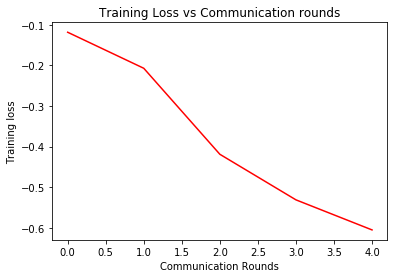

In [16]:
# PLOTTING (optional)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')

# Plot Loss curve
plt.figure()
plt.title('Training Loss vs Communication rounds')
plt.plot(range(len(train_loss)), train_loss, color='r')
plt.ylabel('Training loss')
plt.xlabel('Communication Rounds')
# plt.savefig('../save/fed_{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}]_loss.png'.
#             format(args.dataset, args.model, args.epochs, args.frac,
#                    args.iid, args.local_ep, args.local_bs))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

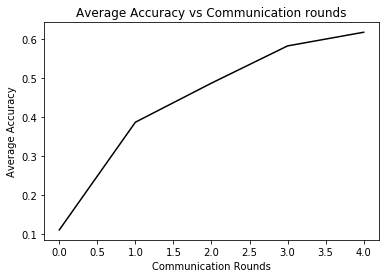

In [17]:
# Plot Average Accuracy vs Communication rounds
plt.figure()
plt.title('Average Accuracy vs Communication rounds')
plt.plot(range(len(train_accuracy)), train_accuracy, color='k')
plt.ylabel('Average Accuracy')
plt.xlabel('Communication Rounds')
# plt.savefig('../save/fed_{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}]_acc.png'.
#             format(args.dataset, args.model, args.epochs, args.frac,
#                    args.iid, args.local_ep, args.local_bs))
plt.show